In [3]:
import tweepy
import sys
import json
import time
import pandas as pd
import numpy as np
import requests
from requests_oauthlib import OAuth1
import datetime as dt
import importlib
import matplotlib.pyplot as plt

import process_tweets

In [4]:
users = pd.read_csv('data/seed_users.csv').screen_name.values

# Tweets from 10-16 may (stream + rest)
### Users: NeilUKIP, TradBritGroup, OhBrokenBritain

In [5]:
stream_list = []
for i in range(10,17):
    with open('data/raw/seed_tweets/stream_tweets_2005%i.json'%i) as json_data:
        stream = json_data.readlines()
        stream = process_tweets.tidy_tweets(stream)
        stream_list.append(stream)
        
stream = pd.concat(stream_list).reset_index(drop=True)

In [6]:
rest_list = []
for i in range(10,17):
    with open('data/raw/seed_tweets/rest_tweets_2005%i.json'%i) as json_data:
        rest = json_data.readlines()
        rest = process_tweets.tidy_tweets(rest)
        rest_list.append(rest)
        
rest = pd.concat(rest_list).reset_index(drop=True).drop_duplicates("id")
rest.datetime = pd.to_datetime(rest.datetime)

In [7]:
tweets = pd.concat([stream,rest[~rest.id.isin(stream.id)]]).reset_index(drop=True)

In [8]:
len(stream)

3820

In [9]:
len(tweets)

4384

In [10]:
tweets['seed_mentions']=tweets.mentions.apply(lambda x: [u for u in users if u in x])
tweets['seed_mentions']=tweets['seed_mentions'].apply(lambda x: x[0] if len(x)>0 else "")
tweets['seed_qt_mentions'] = tweets.qt_status.apply(lambda x: "-" if x is None else x)
tweets['seed_qt_mentions'] = tweets['seed_qt_mentions'].apply(lambda x: [u for u in users if u in x])
tweets['seed_qt_mentions'] = tweets['seed_qt_mentions'].apply(lambda x: x[0] if len(x) > 0 else "")

tweets.loc[(tweets['rt_from_screen_name'].isna()) & (tweets['qt_from_screen_name'].notna()), 'direct_qt'] = tweets['qt_from_screen_name']
tweets.loc[(tweets['rt_from_screen_name'].notna()) & (tweets['qt_from_screen_name'].notna()), 'rt_qt'] = tweets['qt_from_screen_name']
tweets.loc[~(tweets['rt_from_screen_name'].isin(users)) & ~(tweets['qt_from_screen_name'].isin(users)) & ~(tweets['in_reply_to_screen_name'].isin(users)), 'direct_mentions'] = tweets['seed_mentions']
tweets.loc[~(tweets['rt_from_screen_name'].isin(users)) & ~(tweets['qt_from_screen_name'].isin(users)) & ~(tweets['in_reply_to_screen_name'].isin(users)) & ~(tweets['direct_mentions'].isin(users)), 'direct_qt_mentions'] = tweets['seed_qt_mentions']

In [11]:
tweets.head()

,id,screen_name,user_id,text,rt_from_screen_name,rt_from_id,qt_from_screen_name,qt_status,in_reply_to_screen_name,in_reply_to_status,mentions,datetime,seed_mentions,seed_qt_mentions,direct_qt,rt_qt,direct_mentions,direct_qt_mentions
0,1259273169782931465,Rankbrexiteer41,1166735084650717185,Ann’s got the balls! Don't do it Boris! Ann Wi...,OhBrokenBritain,1.259171e+18,None,None,None,NaN,{OhBrokenBritain},2020-05-10 00:04:54,OhBrokenBritain,,NaN,NaN,NaN,NaN
1,1259275149934764037,gasgastony,1861847768,Britain needs some good news and here it is: F...,OhBrokenBritain,1.259030e+18,None,None,None,NaN,{},2020-05-10 00:12:46,,,NaN,NaN,NaN,NaN
2,1259277511319597056,ExForces1,4228172484,@patel4witham And @patel4witham is disrespecti...,OhBrokenBritain,1.258748e+18,None,None,None,NaN,{patel4witham},2020-05-10 00:22:09,,,NaN,NaN,NaN,NaN
3,1259277907404492800,RobIves8,1046475072964300808,Ann’s got the balls! Don't do it Boris! Ann Wi...,OhBrokenBritain,1.259171e+18,None,None,None,NaN,{OhBrokenBritain},2020-05-10 00:23:44,OhBrokenBritain,,NaN,NaN,NaN,NaN
4,1259280641851523073,mark_the_god,2449686481,Ann’s got the balls! Don't do it Boris! Ann Wi...,OhBrokenBritain,1.259171e+18,None,None,None,NaN,{OhBrokenBritain},2020-05-10 00:34:35,OhBrokenBritain,,NaN,NaN,NaN,NaN


In [12]:
print("Total tweets collected: ",len(tweets))
print("Tweets by seed users: ",len(tweets[tweets.screen_name.isin(users)]))
print("Self retweets: ",len(tweets[(tweets.rt_from_screen_name.isin(users))&(tweets.screen_name.isin(users))]))
print("Retweets: ",len(tweets[(tweets.rt_from_screen_name.isin(users))&~(tweets.screen_name.isin(users))]))
print("Retweeted quotes: ",len(tweets[(tweets.qt_from_screen_name.isin(users)) & tweets.rt_from_screen_name.notna()]))
print("Direct quotes: ",len(tweets[(tweets.qt_from_screen_name.isin(users)) & tweets.rt_from_screen_name.isna()]))
print("Replies: ",len(tweets[(tweets.in_reply_to_screen_name.isin(users)) & (tweets.rt_from_screen_name.isna())]))
print("Direct mentions: ", len(tweets[(tweets.direct_mentions.isin(users))]))
print("Direct qt mentions: ", len(tweets[(tweets.direct_qt_mentions.isin(users))]))

Total tweets collected:  4384
Tweets by seed users:  194
Self retweets:  23
Retweets:  2694
Retweeted quotes:  175
Direct quotes:  60
Replies:  524
Direct mentions:  661
Direct qt mentions:  29


In [ ]:
# <1%
# The rest are quotes from quotes from our seed users, or
# user_names that have in their description one of the seed_users or
# Users that rt or qt users that have in their description one of the seed_users ex https://twitter.com/CymruUKIP/status/1258088102310154252

## Tweets by seed users

In [13]:
tweets_by_seed = tweets[tweets.screen_name.isin(users)]; print(len(tweets_by_seed))

194


In [14]:
counts = tweets_by_seed[['screen_name','rt_from_screen_name','rt_qt','direct_qt','in_reply_to_screen_name','direct_mentions']]\
                .apply(pd.Series.value_counts)\
                .loc[['OhBrokenBritain','TradBritGroup','NeilUKIP']]
percentages = counts.div(counts.sum(axis=1), axis=0)
counts = counts.reset_index()
counts.columns = ["screen_name", "seed_tweets", "retweets", "retweets_from_quotes", "quotes", "replies","mentions"]
percentages = percentages.reset_index()
percentages.columns = ["screen_name", "seed_tweets", "retweets", "retweets_from_quotes", "quotes", "replies","mentions"]

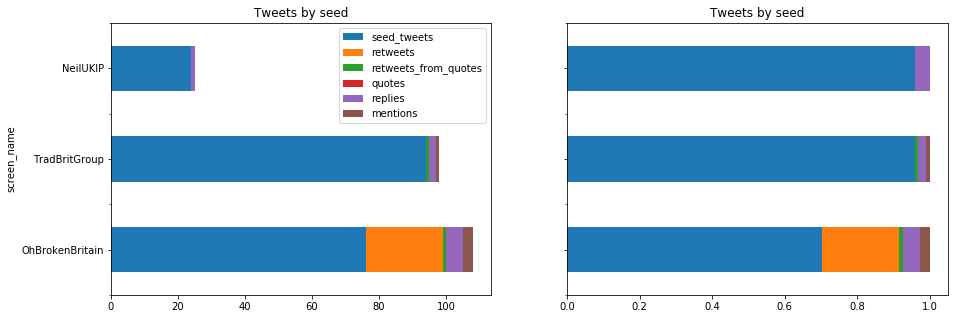

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)
counts.plot(x="screen_name", y=["seed_tweets", "retweets", "retweets_from_quotes", "quotes", "replies",'mentions'],
            kind="barh",
            stacked=True,
            title="Tweets by seed",
            ax=axes[0])

percentages.plot(x="screen_name", y=["seed_tweets", "retweets", "retweets_from_quotes", "quotes", "replies",'mentions'],
            kind="barh",
            stacked=True,
            title="Tweets by seed",
            legend=False,
            ax=axes[1])

## Tweets by other users

In [16]:
tweets_by_others = tweets[~tweets.screen_name.isin(users)]; print(len(tweets_by_others))

4190


In [17]:
counts = tweets_by_others[['screen_name','rt_from_screen_name','rt_qt','direct_qt','in_reply_to_screen_name','direct_mentions']]\
                .apply(pd.Series.value_counts)\
                .loc[['OhBrokenBritain','TradBritGroup','NeilUKIP']]
percentages = counts.div(counts.sum(axis=1), axis=0)
counts = counts.reset_index()
counts.columns = ["screen_name", "seed_tweets", "retweets", "retweets_from_quotes", "quotes", "replies","mentions"]
percentages = percentages.reset_index()
percentages.columns = ["screen_name", "seed_tweets", "retweets", "retweets_from_quotes", "quotes", "replies","mentions"]

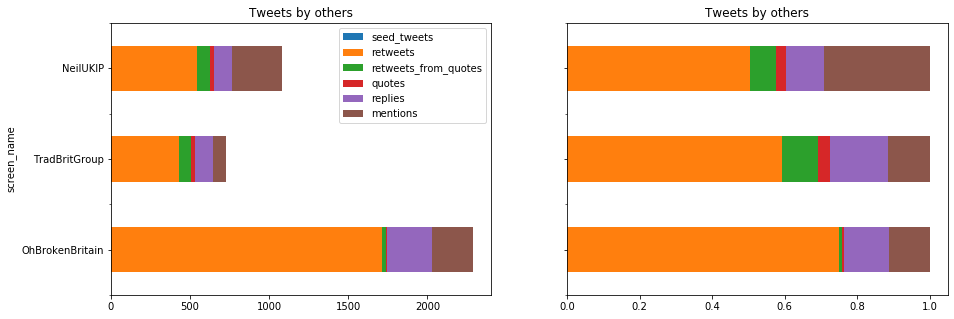

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)
counts.plot(x="screen_name", y=["seed_tweets", "retweets", "retweets_from_quotes", "quotes", "replies",'mentions'],
            kind="barh",
            stacked=True,
            title="Tweets by others",
            ax=axes[0])

percentages.plot(x="screen_name", y=["seed_tweets", "retweets", "retweets_from_quotes", "quotes", "replies",'mentions'],
            kind="barh",
            stacked=True,
            title="Tweets by others",
            legend=False,
            ax=axes[1])

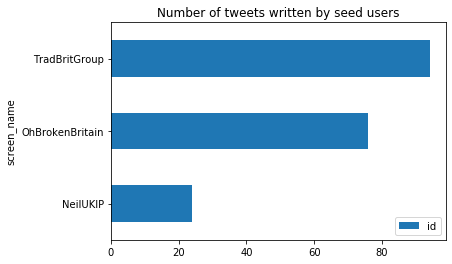

In [19]:
(tweets[tweets.screen_name.isin(users)][['screen_name','id']]
                            .groupby('screen_name')
                            .count()
                            .plot(kind='barh', title='Number of tweets written by seed users'))

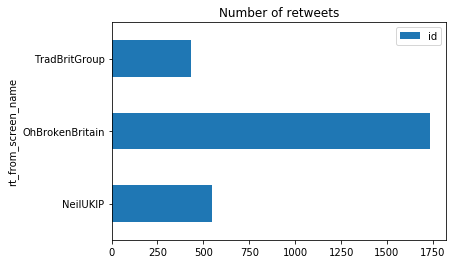

In [20]:
(tweets[tweets.rt_from_screen_name.isin(users)][['rt_from_screen_name','id']]
                            .groupby('rt_from_screen_name')
                            .count()
                            .plot(kind='barh', title='Number of retweets'))

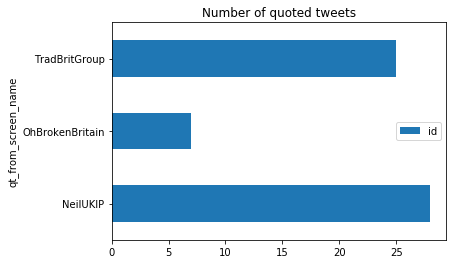

In [21]:
(tweets[(tweets.qt_from_screen_name.isin(users)) & (tweets.rt_from_screen_name.isna())][['qt_from_screen_name','id']]
                            .groupby('qt_from_screen_name')
                            .count()
                            .plot(kind='barh', title='Number of quoted tweets'))

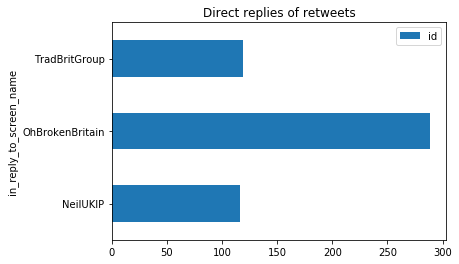

In [22]:
(tweets[tweets.in_reply_to_screen_name.isin(users)]
                            [['in_reply_to_screen_name','id']]
                            .groupby('in_reply_to_screen_name')
                            .count()
                            .plot(kind='barh', title='Direct replies of retweets'))